# Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization

In [1]:
# Run this cell if you are on external server like colab or kaggle. (Useful to train on GPU)
# !git clone "https://github.com/mathisemb/AdaIN.git"
# %cd AdaIN

## Imports

In [1]:
import torch
from PIL import Image
from utils.plot_tools import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Training of the decoder

### Dataloaders

Choose between one of the two following cells.

In [ ]:
# Choose Dataset 

cifar_artbench = True

# If False, mscoco_wikiart will be selected.

In [10]:
if cifar_artbench :
    from utils.dataloader_maker_cifar_artbench import dataloader_maker, undo_normalization

    content_loader, style_loader = dataloader_maker(nb_of_images=1024, batch_size=8)
    
else : 
    from utils.dataloader_maker_mscoco_wikiart import dataloader_maker, undo_normalization

    content_path = 'utils/datasets/MS_COCO_val'
    content_loader = dataloader_maker(folder_path= content_path, nb_of_images=8, batch_size=8)
    style_path = 'utils/datasets/wikiart/wikiart'
    style_loader = dataloader_maker(folder_path= style_path, nb_of_images=8, batch_size=8)

Files already downloaded and verified
Files already downloaded and verified


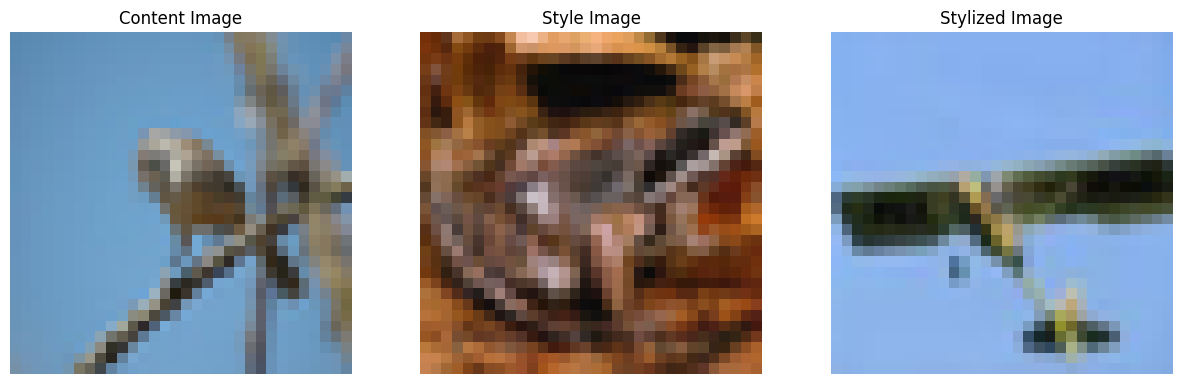

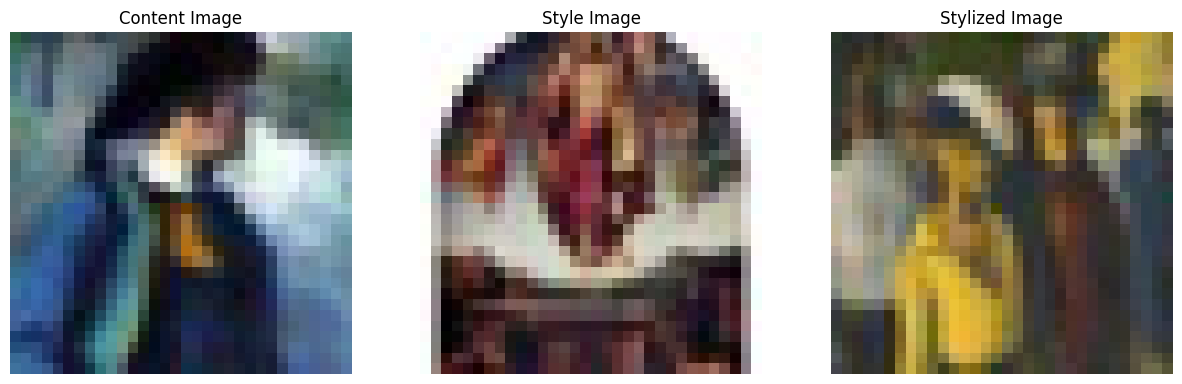

In [11]:
# Show some images
for img in content_loader :
    img = undo_normalization(img[0])
    plot_img(img[0],img[1], img[2])
    break
for img in style_loader :
    img = undo_normalization(img[0])
    plot_img(img[0],img[1], img[2])
    break

## Define the model

In [12]:
from model import StyleTransfer
lr = 3e-4
lam = 20.
model = StyleTransfer(lr=lr, lam=lam)

Using cache found in /Users/gurvanrichardeau/.cache/torch/hub/pytorch_vision_v0.9.0


### Training the decoder

In [13]:
# Training
nb_epochs = 10
model.train_decoder(content_loader, style_loader, nb_epochs)

Epochs:   0%|          | 0/10 [00:09<?, ?it/s][E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument



KeyboardInterrupt: 

### Plot Loss

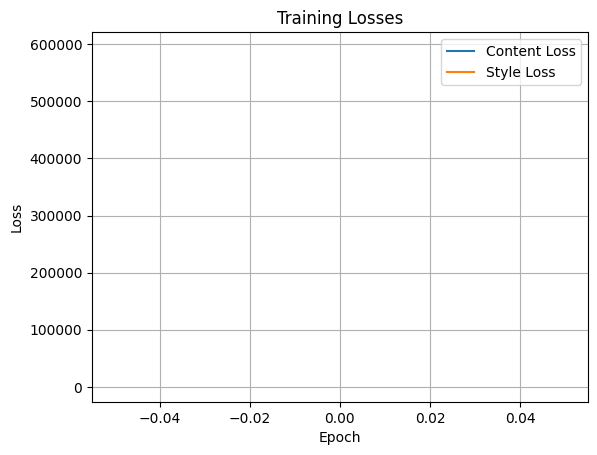

In [9]:
plot_losses(model.LOSS[0], model.LOSS[1])

### Saving model

In [ ]:
# Will automatically be saved into the saving_path : 'model_checkpoints/Adain/'
model.save()

### Loading model to retrain it

The loading is carried out in such a way that the era returns to where it was, and the list of all losses is continued and not overwritten.

In [ ]:
model = StyleTransfer(lr, lam)
checkpoint_epoch = 50 #Choose which model you want to load, see them in the saving_path : 'model_checkpoints/Adain/'


model.load(epoch=checkpoint_epoch)

model.train_decoder(content_loader, style_loader, nb_epochs)
model.save()

# Evaluating the model

## Load and preprocess the images

In [14]:
import torchvision.transforms as transforms
from utils.dataloader_maker_mscoco_wikiart import mean_rgb

if cifar_artbench :
    content_img = Image.open('images/content/golden_gate.jpg')
    style_img = Image.open('images/style/sketch.png')
    resize = (32, 32)
else : 
    # Load the content and style images
    content_img = Image.open("images/content/000000000785.jpg")
    style_img = Image.open("images/style/albert-marquet_life-class-at-the-cole-des-beaux-arts-fauvist-nude-1898.jpg")
    resize = (256, 256)

# Preprocess the images
preprocess = transforms.Compose([
    transforms.Resize(resize),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_rgb, std=[1, 1, 1]),  # Subtract mean
    lambda x: x * 255  # Multiply by 255
])
content_tensor = preprocess(content_img).unsqueeze(0).to(device)
style_tensor = preprocess(style_img).unsqueeze(0).to(device)

NameError: name 'cifar_artbench' is not defined

## Load and Run the model

In [12]:
load_checkpoint = checkpoint_epoch + nb_epochs
#load_checkpoint = 50
print(load_checkpoint)

model = StyleTransfer()
model.load(load_checkpoint)

with torch.no_grad():
    for content, style in zip(content_loader, style_loader) :
        content_tensor, style_tensor = content[0].to(device), style[0].to(device)
        
        stylized_tensor = model(content_tensor, style_tensor)
        content_img = undo_normalization(content_tensor)
        style_img = undo_normalization(style_tensor)
        stylized_img = undo_normalization(stylized_tensor)
        
        for k, (content, style, stylized) in enumerate(zip(content_img, style_img, stylized_img)) :
            saving_path = f'/kaggle/working/AdaIN/images/cifar_train_figures/checkpoint_{load_checkpoint}_fig{k}.png'
            plot_img(content, style, stylized, saving_path)
        break

Using cache found in /Users/gurvanrichardeau/.cache/torch/hub/pytorch_vision_v0.9.0
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
